In [1]:
#Backtesting investment strategies across different sectors using the ACSI scores

In [1]:
#Import packages
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import scipy
from scipy import stats
from scipy.stats import pearsonr
from collections import Counter
import collections
!pip install FundamentalAnalysis
import FundamentalAnalysis as fa
!pip install empyrical
import empyrical

!pip install quantstats
import quantstats as qs
qs.extend_pandas()

  Created wheel for FundamentalAnalysis: filename=FundamentalAnalysis-0.2.6-cp36-none-any.whl size=9734 sha256=229c37130fd99494b4f905fd517df3fcec4b75c576ab71ded0a689274ea7bd2b
  Stored in directory: /root/.cache/pip/wheels/d2/09/b7/cae273de32fdaa5dae02f207e91294b40fd1cba026448116a3
Successfully built FundamentalAnalysis
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for empyrical: filename=empyrical-0.5.3-cp36-none-any.whl size=37087 sha256=915a900478650a2338efeda95c42052a334f7c82926d39ae6675c12b4691513b
  Stored in directory: /root/.cache/pip/wheels/10/a4/3b/951bd609878a82fd72b9ea23699daf1eaada4ff6f583152876
Successfully built empyrical


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


  Created wheel for quantstats: filename=QuantStats-0.0.25-py2.py3-none-any.whl size=36679 sha256=455a6aa2a41b50b94cf5e676fede7b378c1407a3806ba7e984dec3a5ed2eb21c
  Stored in directory: /root/.cache/pip/wheels/c6/6a/f7/742e00f4fd523ec4d6b9665f729f7ea1d26c15ae13445b1178
  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=fd67352e15a5a980cf1516b416fc4ba8d4bd9a42f03d778fcb30a86e227dda07
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built quantstats yfinance


In [2]:
from google.colab import files
files = files.upload()

Saving ASCI_Score_1.csv to ASCI_Score_1.csv


In [3]:
csv_file = open("ASCI_Score_1.csv", "r")
df = pd.read_csv(csv_file)

In [4]:
#include category filter (Private, Public, Defunct, Subsidiary)
def get_acsi_scores(input_df, industry, years, subsidiaries, plot_data, data_format):

  #Splitting the company Name from the company type
  company_type = []
  company_name = []
  for i in input_df['Company Name']:
    i = i.replace("\xa0", "")
    start_point = i.find('[')
    end_point = i.find(']')
    company_type.append(i[start_point+1:end_point])
    company_name.append(i[0:start_point])


  #Selecting the years to remove from the dataframe
  year_options = ['95', '96', '97', '98', '99', '00', '01', '02', '03','04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20']
  years_to_remove = []
  for year in year_options:
    if year in years:
      pass
    else:
      years_to_remove.append(year)


  #removing columns from dataframe
  df3 = pd.DataFrame()
  df3['Company Name'] = company_name
  df3['Company Type'] = company_type
  df2 = df.drop(axis=1, labels=years_to_remove)
  df2 = df2.drop(axis=1, labels=['Company Name', 'Base-\nline', 'Previous\nYear\n%\nChange', 'Notes', 'Type (Public, Subsidiary, Private, Defunct, Government)'])
  #df2 = df2.drop(axis=1, labels=years_to_remove)
  df4 = pd.concat([df3, df2], axis=1)
  df4.dropna(subset=["Ticker Symbol"], inplace=True)

  #Remove all companies without data within these years
  df4.replace("NM", float("NaN"), inplace=True)
  df4.replace("NM***", float("NaN"), inplace=True)
  df4.replace("^", float("NaN"), inplace=True)
  df4.replace("\xa0", float("NaN"), inplace=True)
  df4.replace("#", float("NaN"), inplace=True)
  df4.replace("†", float("NaN"), inplace=True)
  df4.dropna(inplace=True)

  #remove all subsidiaries
  if subsidiaries == False: 
    df4['Division'].replace("Yes", float("NaN"), inplace=True)
    df4.dropna(inplace=True)
    df4.drop(axis = 1, labels = ['Division'], inplace=True)
  
  #df4.reset_index(drop=True)

  count = 0 
  relevant_companies = []
  for i in df4['Company Type']:
    if i == industry:
      relevant_companies.append(count)
    count = count + 1


  #selecting only companies in the selected industry
  if industry == "All":
    df5 = df4
  else:
    df5 = df4.iloc[relevant_companies]



  #convert strings to int
  for k in years:
    df5[str(k)] = df5[str(k)].astype(int)

  #Drop Non-Int Columns for Plotting
  if subsidiaries == False:
    df7 = df5.drop(axis = 1, labels = ['Company Name', 'Company Type', 'Ticker Name', 'Exchange'])
  if subsidiaries == True:
    df7 = df5.drop(axis = 1, labels = ['Company Name', 'Company Type', 'Ticker Name', 'Exchange', 'Division'])
  
  new_index = {}
  count = 0
  for i in df7.columns:
    if count == 0:
      new_index[i] = i
    if count > 0:
      new_index[i] = ("20" + str(i) + "-01-01")
    count = count + 1
  
  df7.rename(new_index, axis='columns', inplace=True)
      
  df7.set_axis(df7['Ticker Symbol'], axis = 0, inplace=True)
  df7.drop(axis = 1, labels = ['Ticker Symbol'], inplace=True)
  df7 = df7.transpose()
  #print(df7)

  if data_format == "Percent":
    df7 = df7.pct_change()

  if plot_data == True:
    df7.plot()
    plt.show()

  return df7

In [5]:
def get_stock_data(backtest_acsi_test):
  stock_data_test = pd.DataFrame()
  for k in backtest_acsi_test.columns:
    sample1 = fa.stock_data(k, period='10y', interval = "1mo")
    first_cut = backtest_acsi_test.index[0]
    last_cut = backtest_acsi_test.index[len(backtest_acsi_test.index)-1]
    count = 0
    for i in sample1.index:
      if str(i) == first_cut:
        first_cut = count
      if str(i) == last_cut:
        #we want January 1st, not december 1st so we get a full year on the last piece of data
        last_cut = count + 1
      count = count + 1
    sample1.iloc[first_cut:last_cut]
    stock_data_test[k] = sample1.iloc[first_cut:last_cut]['open']
      
  return stock_data_test  

In [31]:

def run_backtest(sector, initial_capital):
  '''
  Sectors available: Airlines, Athletic Shoes, Banks, Consumer Shipping, Department and Discount Stores, Fixed-Line Telephone Service, Health and Personal Care Stores, Household Appliances, Internet Investment Services, Internet Retail, Life Insurance, Limited-Service Restaurants, Personal Care and Cleaning Products, Property and Casualty Insurance, Soft Drinks, Specialty Retail Stores, Supermarkets
  '''
  


  #Designing the trading system
  backtest_range = ['12', '13', '14', '15', '16', '17', '18', '19']
  capital = initial_capital
  backtest_acsi_test = get_acsi_scores(df, sector, backtest_range, False, False, "Raw")
  stocktest = get_stock_data(backtest_acsi_test)

  count = 0
  portfolio_dict = {}
  portfolio_dict['Available Funds'] = capital
  for i in stocktest.columns:
    portfolio_dict[i] = 0

  portfolio_worth = []

  time_count = 0
  for i in stocktest.index:



    #If the year changes, time to rebalance the portfolio.
    if str(i) in backtest_acsi_test.index:
      #sell all current positions:
      for j in stocktest.columns:
        #Add the current worth of the position to the available funds
        portfolio_dict['Available Funds'] = portfolio_dict['Available Funds'] + portfolio_dict[j]*stocktest[j][time_count]

        #set the position to zero
        portfolio_dict[j] = 0



      #pull up ACSI data for that date
      score_max = backtest_acsi_test.loc[str(i)].max()
      score_min = backtest_acsi_test.loc[str(i)].min()

      #if the max and min are the same, do nothing
      if score_max == score_min:
        pass
      
      #else, record the ticker with the highest score and the ticker with the lowest score
      else: 
        ticker_long = []
        #ticker_short = []
        count = 0 
        for k in backtest_acsi_test.loc[str(i)]:
          if backtest_acsi_test.loc[str(i)][count] == score_min:
            ticker_long.append(backtest_acsi_test.loc[str(i)].index[count])
          #if backtest_acsi_test.loc[str(i)][count] == score_min:
            #ticker_short.append(backtest_acsi_test.loc[str(i)].index[count])
          count = count + 1
      
      #calculate the number of positions to take
      position_number = len(ticker_long)
      capital_per_position = portfolio_dict['Available Funds']/position_number


      ###LOGGING CODE
      #print(ticker_long)

      #fetch the price of each position, calculate how many shares you can purchase with the available funds, add to portfolio, subtract funding from available capital
      for j in ticker_long:
        #add position quantity to portfolio dictionary
        portfolio_dict[j] = int(capital_per_position/stocktest[j][time_count])
        #print(j, stocktest[j][time_count])

        #subtract the capital used for the purchase from the available funds
        portfolio_dict['Available Funds'] = portfolio_dict['Available Funds'] - portfolio_dict[j]*stocktest[j][time_count]
        
      #print(ticker_long, position_number, capital_per_position)

    #calculate portfolio worth here,
    #set current_worth equal to the available funds
    current_worth = portfolio_dict['Available Funds']
    for j in ticker_long:
      #then add the worth of each position
      current_worth = current_worth + portfolio_dict[j]*stocktest[j][time_count]
    
    #append the information to the portfolio worth list
    portfolio_worth.append(current_worth)
    #print(portfolio_dict)
    

    ####
    time_count = time_count + 1
  low_strategy = portfolio_worth
  #Designing the trading system
  backtest_range = ['12', '13', '14', '15', '16', '17', '18', '19']
  capital = initial_capital
  backtest_acsi_test = get_acsi_scores(df, sector, backtest_range, False, False, "Raw")
  stocktest = get_stock_data(backtest_acsi_test)

  count = 0
  portfolio_dict = {}
  portfolio_dict['Available Funds'] = capital
  for i in stocktest.columns:
    portfolio_dict[i] = 0

  portfolio_worth = []

  time_count = 0
  for i in stocktest.index:



    #If the year changes, time to rebalance the portfolio.
    if str(i) in backtest_acsi_test.index:
      #sell all current positions:
      for j in stocktest.columns:
        #Add the current worth of the position to the available funds
        portfolio_dict['Available Funds'] = portfolio_dict['Available Funds'] + portfolio_dict[j]*stocktest[j][time_count]

        #set the position to zero
        portfolio_dict[j] = 0



      #pull up ACSI data for that date
      score_max = backtest_acsi_test.loc[str(i)].max()
      score_min = backtest_acsi_test.loc[str(i)].min()

      #if the max and min are the same, do nothing
      if score_max == score_min:
        pass
      
      #else, record the ticker with the highest score and the ticker with the lowest score
      else: 
        ticker_long = []
        #ticker_short = []
        count = 0 
        for k in backtest_acsi_test.loc[str(i)]:
          if backtest_acsi_test.loc[str(i)][count] == score_max:
            ticker_long.append(backtest_acsi_test.loc[str(i)].index[count])
          #if backtest_acsi_test.loc[str(i)][count] == score_min:
            #ticker_short.append(backtest_acsi_test.loc[str(i)].index[count])
          count = count + 1
      
      #calculate the number of positions to take
      position_number = len(ticker_long)
      capital_per_position = portfolio_dict['Available Funds']/position_number


      ###LOGGING CODE
      #print(ticker_long)

      #fetch the price of each position, calculate how many shares you can purchase with the available funds, add to portfolio, subtract funding from available capital
      for j in ticker_long:
        #add position quantity to portfolio dictionary
        portfolio_dict[j] = int(capital_per_position/stocktest[j][time_count])
        #print(j, stocktest[j][time_count])

        #subtract the capital used for the purchase from the available funds
        portfolio_dict['Available Funds'] = portfolio_dict['Available Funds'] - portfolio_dict[j]*stocktest[j][time_count]
        
      #print(ticker_long, position_number, capital_per_position)

    #calculate portfolio worth here,
    #set current_worth equal to the available funds
    current_worth = portfolio_dict['Available Funds']
    for j in ticker_long:
      #then add the worth of each position
      current_worth = current_worth + portfolio_dict[j]*stocktest[j][time_count]
    
    #append the information to the portfolio worth list
    portfolio_worth.append(current_worth)
    #print(portfolio_dict)
    

    ####
    time_count = time_count + 1
  high_strategy = portfolio_worth

  #SPY
  #S&P 500 

  spy_data = fa.stock_data('SPY', period='10y', interval = "1mo")
  first_cut = backtest_acsi_test.index[0]
  last_cut = backtest_acsi_test.index[len(backtest_acsi_test.index)-1]
  count = 0
  for i in spy_data.index:
    if str(i) == first_cut:
      first_cut = count
    if str(i) == last_cut:
      #we want January 1st, not december 1st so we get a full year on the last piece of data
      last_cut = count + 1
    count = count + 1
  spy_data.iloc[first_cut:last_cut]
  #spy_data = spy_data.iloc[first_cut:last_cut]['open']
  spy_data = spy_data.iloc[first_cut:last_cut]
  
  capital = initial_capital
  total_stocks = int(capital/spy_data['open'][0])
  capital = capital - total_stocks*spy_data['open'][0]

  spy_portfolio = []
  count = 0
  for i in spy_data['open']:
    spy_portfolio.append(capital + total_stocks*spy_data['open'][count])
    count = count + 1  

  portfolio_df = pd.DataFrame()
  portfolio_df['Low Satisfaction Strategy'] = low_strategy
  portfolio_df['High Satisfaction Strategy'] = high_strategy
  portfolio_df['S&P 500 (Buy & Hold)'] = spy_portfolio
  matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)

  portfolio_df.plot(linestyle = "--")
  plt.title(('Industry: {industry_title}').format(industry_title = sector))
  plt.xlabel('Months')
  plt.ylabel('Portfolio Value (USD)')
  plt.show()

  #Calculate Metrics
  from empyrical import max_drawdown, alpha_beta
  benchmark_delta = np.array([(100 * a1 / a2 - 100)/100 for a1, a2 in zip(spy_portfolio[1:], spy_portfolio)])
  low_strategy_delta = np.array([(100 * a1 / a2 - 100)/100 for a1, a2 in zip(low_strategy[1:], low_strategy)])
  high_strategy_delta = np.array([(100 * a1 / a2 - 100)/100 for a1, a2 in zip(high_strategy[1:], high_strategy)])


  #Low Strategy Drawdown
  alpha, beta = alpha_beta(low_strategy_delta, benchmark_delta)
  print(('Strategy: Investing in Companies in the {sector_name} Sector with Lowest Consumer Satisfaction:').format(sector_name = sector))
  print("Overall Returns (7 Years, 1 Month): " + str(round((low_strategy[len(low_strategy)-1]/initial_capital)*100, 2)) + "%")
  print("Annualized Returns: " + str(round((low_strategy[len(low_strategy)-1]/initial_capital)*100/7.083, 2)) + "%")
  print('Maximum Drawdown:', str(round(max_drawdown(low_strategy_delta)*100, 2)))
  print('Alpha', str(alpha))
  print('Beta', str(beta))
  print('Sharpe Ratio:', qs.stats.sharpe(pd.Series(low_strategy_delta), periods=12))
  print("")


  #High Strategy 
  print(('Strategy: Investing in Companies in the {sector_name} Sector with Highest Consumer Satisfaction:').format(sector_name = sector))
  alpha, beta = alpha_beta(high_strategy_delta, benchmark_delta)
  print("Overall Returns (7 Years, 1 Month): " + str(round((high_strategy[len(high_strategy)-1]/initial_capital)*100, 2)) + "%")
  print("Annualized Returns: " + str(round((high_strategy[len(high_strategy)-1]/initial_capital)*100/7.083, 2)) + "%")
  print('Maximum Drawdown:', str(round(max_drawdown(high_strategy_delta)*100, 2)))
  print('Alpha:', str(alpha))
  print('Beta:', str(beta))
  print('Sharpe Ratio:', qs.stats.sharpe(pd.Series(high_strategy_delta), periods=12))
  print("")


  print("S&P 500:")
  print("Overall Returns (7 Years, 1 Month): " + str(round((spy_portfolio[len(spy_portfolio)-1]/initial_capital)*100, 2)) + "%")
  print("Annualized Returns: " + str(round((spy_portfolio[len(spy_portfolio)-1]/initial_capital)*100/7.083, 2)) + "%")
  print('Maximum Drawdown:', str(round(max_drawdown(benchmark_delta)*100, 2)))
  print('Sharpe Ratio:', qs.stats.sharpe(pd.Series(benchmark_delta), periods=12))






  




 




  


  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



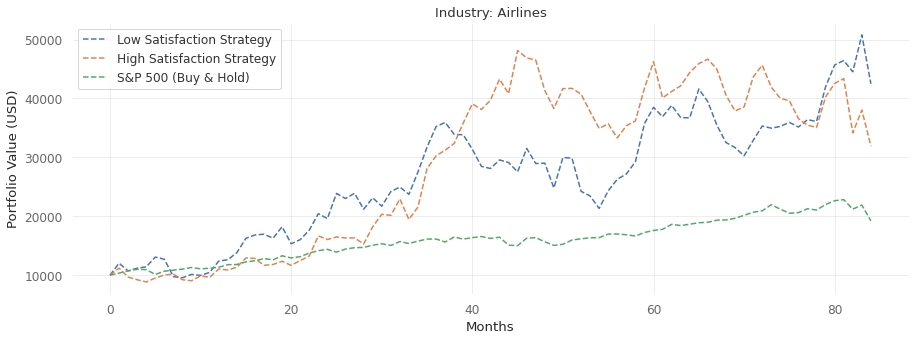

Strategy: Investing in Companies in the Airlines Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 424.79%
Annualized Returns: 59.97%
Maximum Drawdown: -40.62
Alpha 42.07138343780402
Beta 0.8421261640891837
Sharpe Ratio: 0.7791973121870731

Strategy: Investing in Companies in the Airlines Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 319.01%
Annualized Returns: 45.04%
Maximum Drawdown: -33.71
Alpha: 11.246672401012056
Beta: 0.9615649138508808
Sharpe Ratio: 0.6753501294647231

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [32]:
run_backtest('Airlines', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



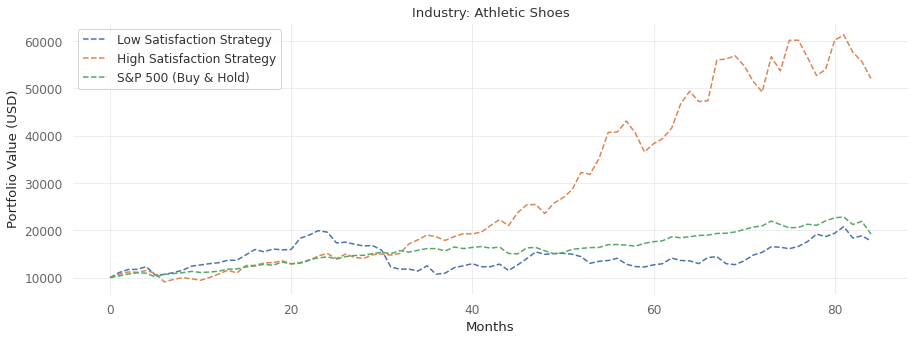

Strategy: Investing in Companies in the Athletic Shoes Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 177.73%
Annualized Returns: 25.09%
Maximum Drawdown: -46.28
Alpha 0.37600897639558917
Beta 0.9358907684304896
Sharpe Ratio: 0.47745085270812293

Strategy: Investing in Companies in the Athletic Shoes Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 520.99%
Annualized Returns: 73.55%
Maximum Drawdown: -20.98
Alpha: 70.14516691680807
Beta: 0.5847107314778042
Sharpe Ratio: 1.1529551317089157

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [33]:
run_backtest('Athletic Shoes', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



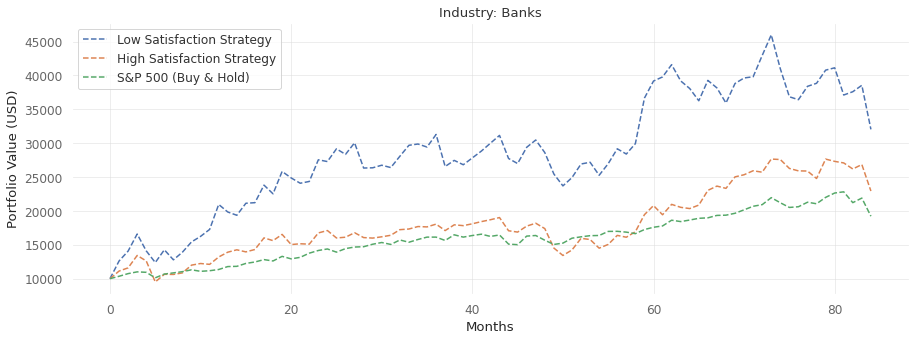

Strategy: Investing in Companies in the Banks Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 320.39%
Annualized Returns: 45.23%
Maximum Drawdown: -30.33
Alpha 2.7731561070942954
Beta 1.457922155338597
Sharpe Ratio: 0.7113193891553778

Strategy: Investing in Companies in the Banks Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 229.36%
Annualized Returns: 32.38%
Maximum Drawdown: -29.42
Alpha: 0.17699880524449774
Beta: 1.386636240936743
Sharpe Ratio: 0.6299793962398433

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [34]:
run_backtest('Banks', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



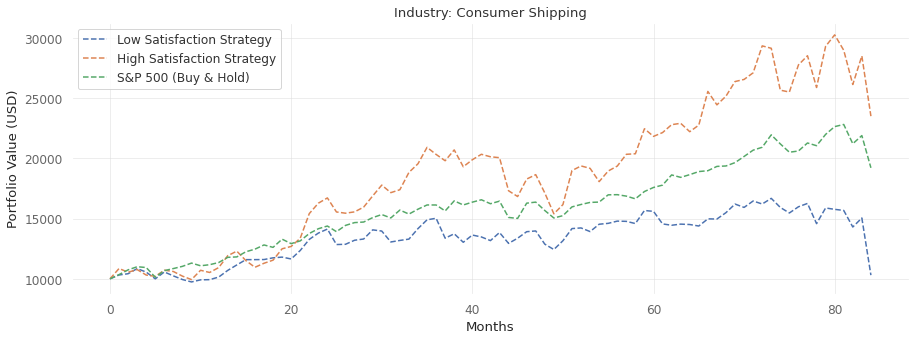

Strategy: Investing in Companies in the Consumer Shipping Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 103.06%
Annualized Returns: 14.55%
Maximum Drawdown: -38.22
Alpha -0.8745142761436351
Beta 1.2250946733541501
Sharpe Ratio: 0.12773231626417786

Strategy: Investing in Companies in the Consumer Shipping Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 235.11%
Annualized Returns: 33.19%
Maximum Drawdown: -26.39
Alpha: 0.6436410949981779
Beta: 1.223488959595088
Sharpe Ratio: 0.6710231892840478

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [35]:
run_backtest('Consumer Shipping', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



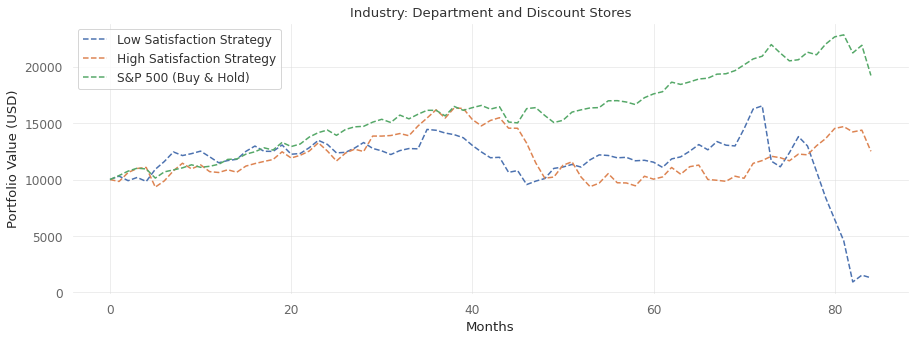

Strategy: Investing in Companies in the Department and Discount Stores Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 12.96%
Annualized Returns: 1.83%
Maximum Drawdown: -94.39
Alpha -0.9882847587599249
Beta 0.9525311219016583
Sharpe Ratio: -0.23981903002726326

Strategy: Investing in Companies in the Department and Discount Stores Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 125.03%
Annualized Returns: 17.65%
Maximum Drawdown: -42.69
Alpha: -0.5434557052689364
Beta: 0.903128469392981
Sharpe Ratio: 0.25920454233749746

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [36]:
run_backtest('Department and Discount Stores', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



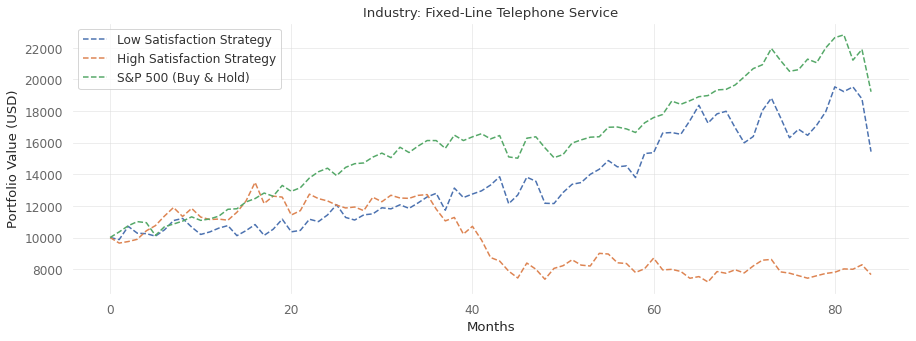

Strategy: Investing in Companies in the Fixed-Line Telephone Service Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 154.32%
Annualized Returns: 21.79%
Maximum Drawdown: -20.98
Alpha -0.24973515252085
Beta 0.926493016405924
Sharpe Ratio: 0.4304618227759063

Strategy: Investing in Companies in the Fixed-Line Telephone Service Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 76.55%
Annualized Returns: 10.81%
Maximum Drawdown: -46.69
Alpha: -0.8310054857182042
Beta: 0.6239014844500695
Sharpe Ratio: -0.12031502163760624

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [37]:
run_backtest('Fixed-Line Telephone Service', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



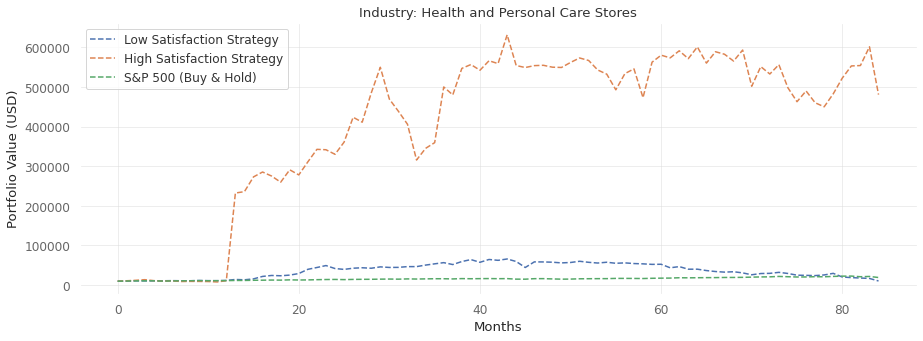

Strategy: Investing in Companies in the Health and Personal Care Stores Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 104.61%
Annualized Returns: 14.77%
Maximum Drawdown: -84.14
Alpha -0.8013665553404189
Beta 1.6861672890699664
Sharpe Ratio: 0.22312103350757848

Strategy: Investing in Companies in the Health and Personal Care Stores Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 4806.62%
Annualized Returns: 678.61%
Maximum Drawdown: -42.57
Alpha: 3.050151929376935e+18
Beta: 7.812151669778223
Sharpe Ratio: 0.4027853724808419

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [38]:
run_backtest('Health and Personal Care Stores', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



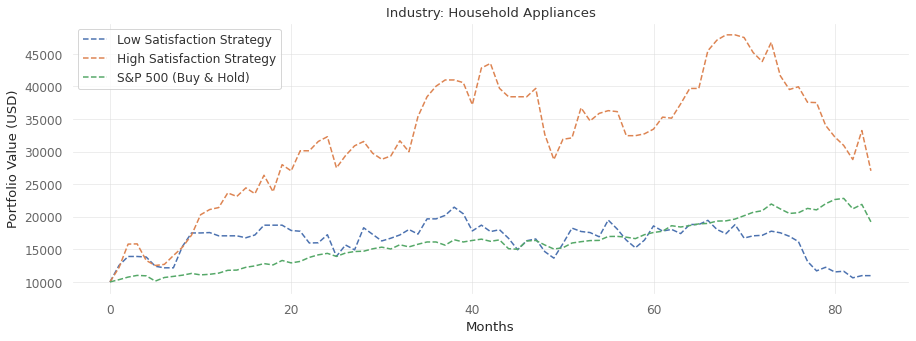

Strategy: Investing in Companies in the Household Appliances Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 109.67%
Annualized Returns: 15.48%
Maximum Drawdown: -50.49
Alpha -0.5590123798496618
Beta 0.9562669146585753
Sharpe Ratio: 0.18835113120683836

Strategy: Investing in Companies in the Household Appliances Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 270.54%
Annualized Returns: 38.2%
Maximum Drawdown: -43.53
Alpha: 2.9060895863610465
Beta: 1.2335807349056436
Sharpe Ratio: 0.6130757003011498

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [39]:
run_backtest('Household Appliances', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



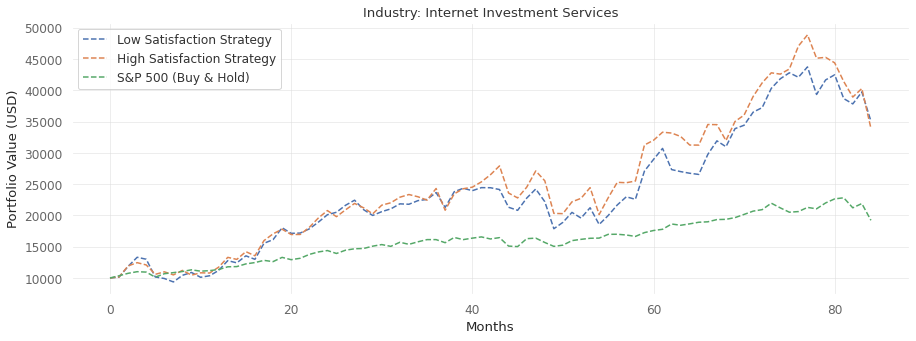

Strategy: Investing in Companies in the Internet Investment Services Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 350.8%
Annualized Returns: 49.53%
Maximum Drawdown: -29.65
Alpha 4.049307992110311
Beta 1.3931301219155696
Sharpe Ratio: 0.8047723274107449

Strategy: Investing in Companies in the Internet Investment Services Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 339.42%
Annualized Returns: 47.92%
Maximum Drawdown: -30.54
Alpha: 3.5175753817731756
Beta: 1.3986039213319041
Sharpe Ratio: 0.7862918616689636

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [40]:
run_backtest('Internet Investment Services', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



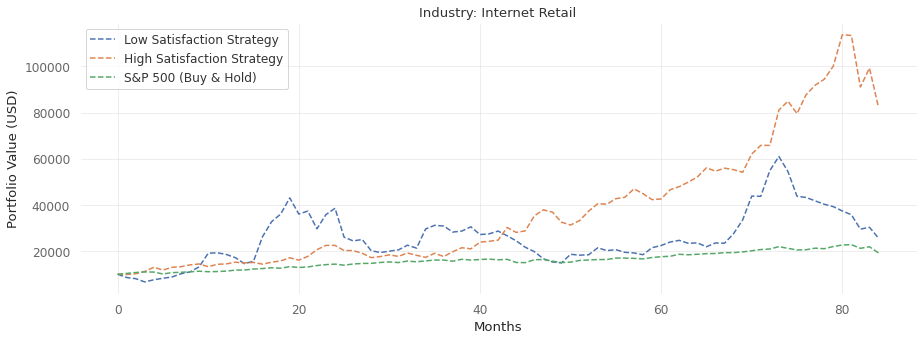

Strategy: Investing in Companies in the Internet Retail Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 256.26%
Annualized Returns: 36.18%
Maximum Drawdown: -65.38
Alpha 23.02001354279947
Beta 1.0920742344823475
Sharpe Ratio: 0.49151232694934954

Strategy: Investing in Companies in the Internet Retail Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 822.01%
Annualized Returns: 116.05%
Maximum Drawdown: -27.66
Alpha: 49.98044224291698
Beta: 1.5452888463533316
Sharpe Ratio: 1.2141534939456826

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [41]:
run_backtest('Internet Retail', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



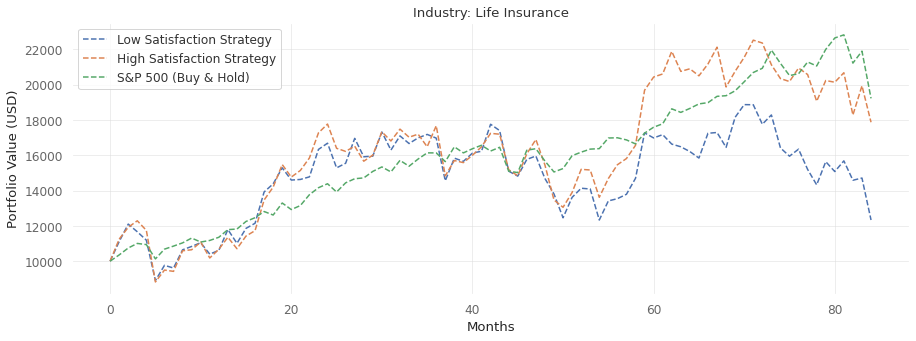

Strategy: Investing in Companies in the Life Insurance Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 123.32%
Annualized Returns: 17.41%
Maximum Drawdown: -34.64
Alpha -0.8296613628249003
Beta 1.4449032218911835
Sharpe Ratio: 0.24523420728223086

Strategy: Investing in Companies in the Life Insurance Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 178.7%
Annualized Returns: 25.23%
Maximum Drawdown: -28.2
Alpha: -0.4959520747605405
Beta: 1.4659252647996066
Sharpe Ratio: 0.4629438986127197

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [42]:
run_backtest('Life Insurance', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



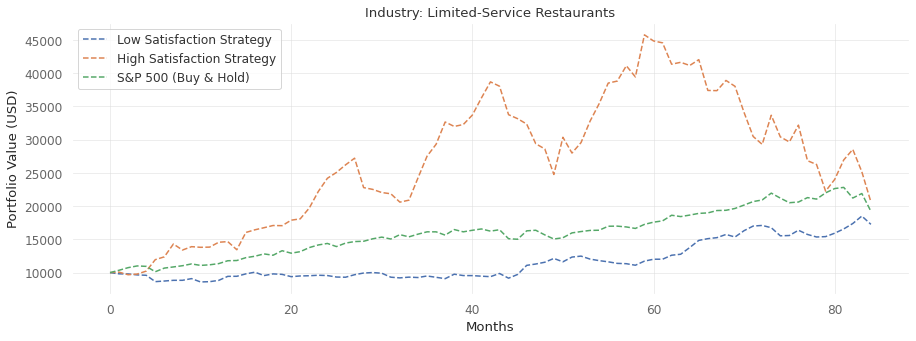

Strategy: Investing in Companies in the Limited-Service Restaurants Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 172.6%
Annualized Returns: 24.37%
Maximum Drawdown: -14.04
Alpha 0.9028123153585106
Beta 0.5665206228372184
Sharpe Ratio: 0.6365556168794433

Strategy: Investing in Companies in the Limited-Service Restaurants Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 206.3%
Annualized Returns: 29.13%
Maximum Drawdown: -54.92
Alpha: 9.960505723331185
Beta: 0.3245658324158606
Sharpe Ratio: 0.4964236521206111

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [43]:
run_backtest('Limited-Service Restaurants', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



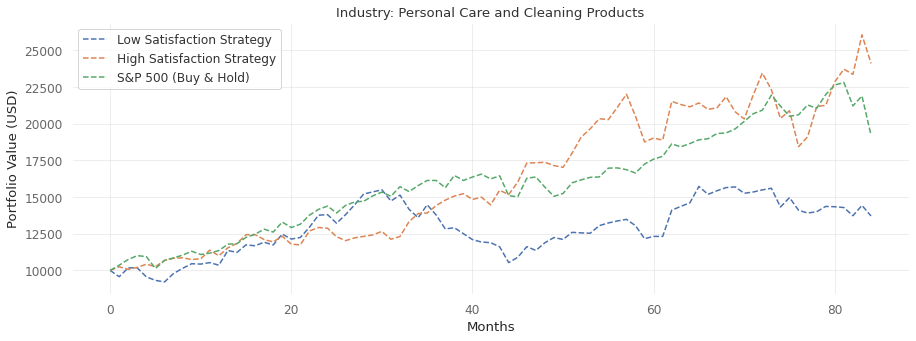

Strategy: Investing in Companies in the Personal Care and Cleaning Products Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 137.12%
Annualized Returns: 19.36%
Maximum Drawdown: -32.04
Alpha -0.15887963453153542
Beta 0.6377832390981479
Sharpe Ratio: 0.3799941654231043

Strategy: Investing in Companies in the Personal Care and Cleaning Products Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 241.19%
Annualized Returns: 34.05%
Maximum Drawdown: -21.4
Alpha: 5.50233045441134
Beta: 0.4888137346422071
Sharpe Ratio: 0.8830983150641256

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [44]:
run_backtest('Personal Care and Cleaning Products', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



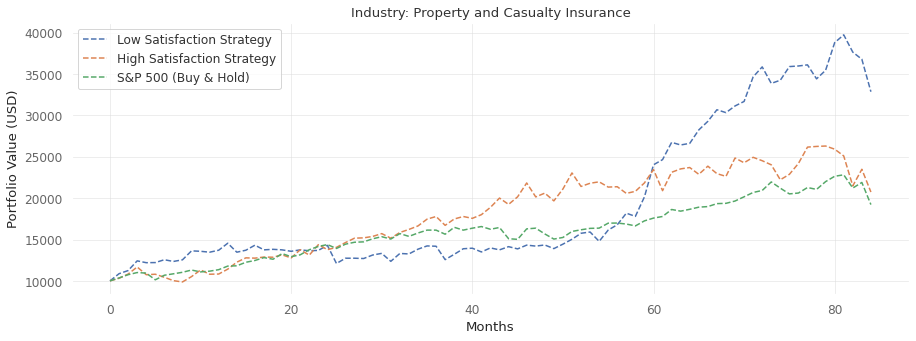

Strategy: Investing in Companies in the Property and Casualty Insurance Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 328.67%
Annualized Returns: 46.4%
Maximum Drawdown: -17.29
Alpha 10.356692697412765
Beta 0.7122373552878437
Sharpe Ratio: 1.0245728834740935

Strategy: Investing in Companies in the Property and Casualty Insurance Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 207.4%
Annualized Returns: 29.28%
Maximum Drawdown: -21.14
Alpha: 1.8369808302206967
Beta: 0.7110013289339572
Sharpe Ratio: 0.6677975155118434

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [45]:
run_backtest('Property and Casualty Insurance', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



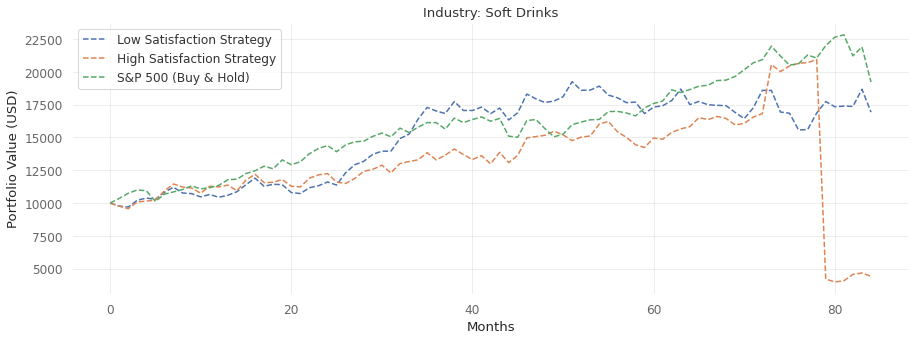

Strategy: Investing in Companies in the Soft Drinks Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 169.29%
Annualized Returns: 23.9%
Maximum Drawdown: -19.09
Alpha 0.7629506950542344
Beta 0.5754251917189338
Sharpe Ratio: 0.6177964325111597

Strategy: Investing in Companies in the Soft Drinks Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 44.2%
Annualized Returns: 6.24%
Maximum Drawdown: -80.94
Alpha: -0.0288324814817551
Beta: 0.10865964112629535
Sharpe Ratio: 0.027879638536211743

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [46]:
run_backtest('Soft Drinks', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



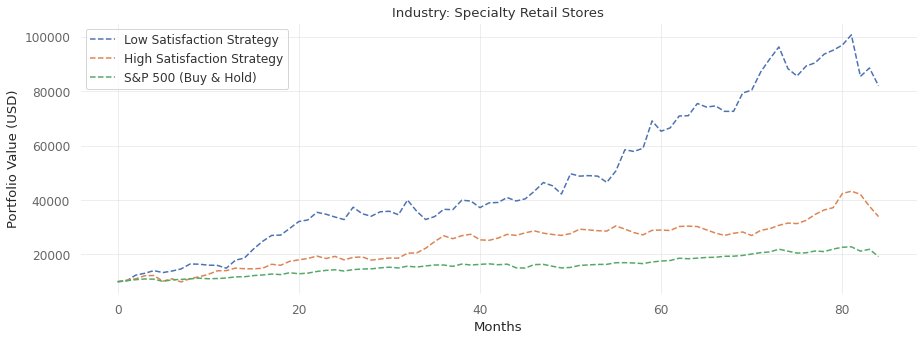

Strategy: Investing in Companies in the Specialty Retail Stores Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 819.3%
Annualized Returns: 115.67%
Maximum Drawdown: -18.59
Alpha 95.23418293446136
Beta 1.131796025403221
Sharpe Ratio: 1.3563663488916702

Strategy: Investing in Companies in the Specialty Retail Stores Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 339.17%
Annualized Returns: 47.89%
Maximum Drawdown: -21.56
Alpha: 8.982771822371438
Beta: 0.8398751675641927
Sharpe Ratio: 1.0062415457974079

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [47]:
run_backtest('Specialty Retail Stores', 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



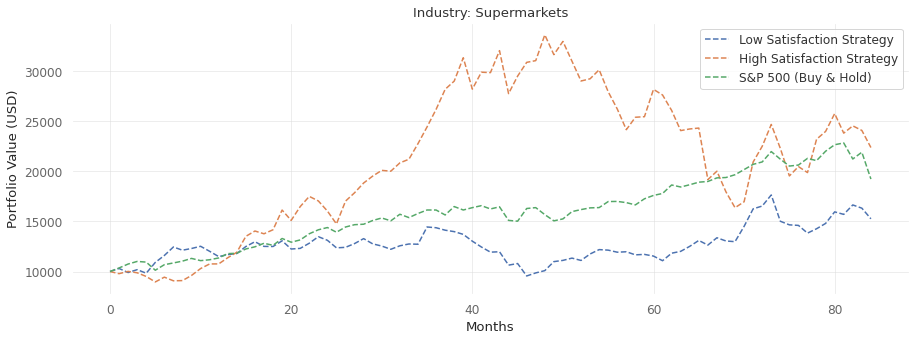

Strategy: Investing in Companies in the Supermarkets Sector with Lowest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 152.57%
Annualized Returns: 21.54%
Maximum Drawdown: -33.83
Alpha 1.5187456255173717
Beta 0.3154775550337494
Sharpe Ratio: 0.4316856572133327

Strategy: Investing in Companies in the Supermarkets Sector with Highest Consumer Satisfaction:
Overall Returns (7 Years, 1 Month): 223.62%
Annualized Returns: 31.57%
Maximum Drawdown: -51.29
Alpha: 3.990618174085381
Beta: 0.7110163791876398
Sharpe Ratio: 0.5769735813672586

S&P 500:
Overall Returns (7 Years, 1 Month): 192.21%
Annualized Returns: 27.14%
Maximum Drawdown: -15.77
Sharpe Ratio: 0.8802842660752008


In [48]:
run_backtest('Supermarkets', 10000)